In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
import scikitplot as skplt

from IPython.display import Image
from itertools import cycle
from mpl_toolkits.mplot3d import Axes3D
from scipy import interp
from scipy.stats import randint as sp_randint
from sklearn import metrics, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, accuracy_score, confusion_matrix, classification_report, make_scorer, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize, MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import export_graphviz
from sklearn.utils import resample

# Classification (with statistically assigned labels)

In [2]:
customer_profile = pd.read_csv('datasets/customer_indicators.csv', index_col=0)

In [3]:
ranges = [0.3, 0.7]
quantiles_m = customer_profile.quantile(q=ranges)
quantiles_m['RMonetary']

0.3      7.145611
0.7    127.860000
Name: RMonetary, dtype: float64

In [4]:
quantiles_d = customer_profile.quantile(q=ranges)
quantiles_d['Delta']

0.3      1.0
0.7    224.0
Name: Delta, dtype: float64

In [5]:
quantiles_r = customer_profile.quantile(q=ranges)
quantiles_r['Recency']

0.3     22.0
0.7    109.0
Name: Recency, dtype: float64

In [6]:
def ScoreMD(x, data, thresh, ranges):
    if x <= thresh[data][ranges[0]]:
        return 1
    elif x <= thresh[data][ranges[1]]:
        return 2
    else:
        return 3

def ScoreR(x, data, thresh, ranges):
    if x <= thresh[data][ranges[0]]:
        return 3
    elif x <= thresh[data][ranges[1]]:
        return 2
    else:
        return 1

In [7]:
customer_profile['MScore'] = customer_profile['RMonetary'].apply(ScoreMD, args=('RMonetary', quantiles_m, ranges))
customer_profile['DScore'] = customer_profile['Delta'].apply(ScoreMD, args=('Delta', quantiles_d, ranges))
customer_profile['RScore'] = customer_profile['Recency'].apply(ScoreR, args=('Recency', quantiles_r, ranges))
customer_profile['Score'] = (0.3 * customer_profile['MScore']
                           + 0.4 * customer_profile['DScore']
                           + 0.3 * customer_profile['RScore'])

In [8]:
ranges = [0.2, 0.7]
quantiles = customer_profile.quantile(q=ranges)

In [9]:
def Score(x, data, thresh, ranges):
    if x <= thresh[data][ranges[0]]:
        return 'Low'
    elif x <= thresh[data][ranges[1]]:
        return 'Medium'
    else:
        return 'High'

In [10]:
customer_labeled = customer_profile.copy()
customer_labeled['Label'] = customer_labeled['Score'].apply(Score, args=('Score', quantiles, ranges))
customer_labeled.head()

df_majority = customer_labeled[customer_labeled.Label == 'Medium']
df_minority = customer_labeled[customer_labeled.Label == 'High']
df_middle   = customer_labeled[customer_labeled.Label == 'Low']

customer_labeled.Label.value_counts()

Medium    2059
High      1227
Low       1036
Name: Label, dtype: int64

In [11]:
'''customer_labeled['Delta'] = customer_labeled[['Delta']].apply(np.log10, axis=1).round(3)
customer_labeled['RMonetary'] = customer_labeled[['RMonetary']].apply(np.log10, axis=1).round(3)'''

"customer_labeled['Delta'] = customer_labeled[['Delta']].apply(np.log10, axis=1).round(3)\ncustomer_labeled['RMonetary'] = customer_labeled[['RMonetary']].apply(np.log10, axis=1).round(3)"

In [12]:
'''fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(customer_labeled['Delta'], customer_labeled['Recency'], customer_labeled['RMonetary'],
           c=customer_labeled['Label_num'])
ax.set_xlabel('Delta')
ax.set_ylabel('Recency')
ax.set_zlabel('Relative Monetary')
plt.show()'''

"fig = plt.figure()\nax = Axes3D(fig)\nax.scatter(customer_labeled['Delta'], customer_labeled['Recency'], customer_labeled['RMonetary'],\n           c=customer_labeled['Label_num'])\nax.set_xlabel('Delta')\nax.set_ylabel('Recency')\nax.set_zlabel('Relative Monetary')\nplt.show()"

In [13]:
# Oversample minority classes

df_minority_oversampled = resample(df_minority,
                                   replace=True, # sample with replacement
                                   n_samples=len(df_majority))

df_middle_oversampled = resample(df_middle,
                                 replace=True,
                                 n_samples=len(df_majority))

# Combine majority class with oversampled minority classes
df_oversampled = pd.concat([df_majority, df_minority_oversampled, df_middle_oversampled])
 
# Display new class counts
customer_labeled = df_oversampled
df_oversampled.Label.value_counts()

High      2059
Low       2059
Medium    2059
Name: Label, dtype: int64

In [14]:
# Function to discretize the variables
# Input: the dataset and the list of variables' names to discretize

def discretize_data(dataset, variables):
    for variable in variables:
        mapping = {'High': 0, 'Medium': 1, 'Low': 2}

        # Add a new colum with the number representation of the variable
        dataset[variable + '_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [15]:
variables = ['Label']

# Discretize data, in this case only Label
customer_labeled = discretize_data(customer_labeled, variables)

# Drop the categorical variables since we don't need them anymore
customer_labeled = customer_labeled[['Recency', 'RFrequency', 'Label_num']]

label = customer_labeled.pop('Label_num')

scaler = MinMaxScaler()
customer_labeled = scaler.fit_transform(customer_labeled.values)

train_set, test_set, train_label, test_label = train_test_split(
                                                 customer_labeled, label, stratify=label, test_size=0.3)

In [16]:
train_label.head()

336     0
245     2
178     0
1736    0
2231    2
Name: Label_num, dtype: int64

## Expected prediction

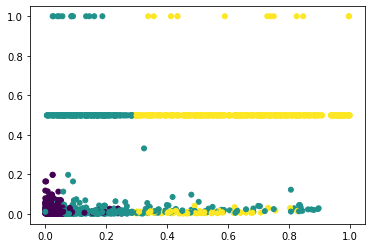

In [17]:
# x: Recency
# y: Frequency
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_label.values, s=25)

## Decision Tree

In [18]:
# Decision tree

param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "criterion": ["entropy", "gini"],
              "splitter": ["best", "random"]
              }

n_iter_search = 50

dec_t = tree.DecisionTreeClassifier()
grid_search = RandomizedSearchCV(dec_t, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score)).fit(train_set, train_label)

In [19]:
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 16, 'min_samples_split': 48, 'splitter': 'best'}
Mean and std of this setting  0.8986836330550204 0.012213305947252727


In [20]:
# Decision tree

dec_t = tree.DecisionTreeClassifier(criterion='gini',
                                    splitter='best',
                                    max_depth=5,
                                    min_samples_split=23,
                                    min_samples_leaf=48).fit(train_set, train_label)

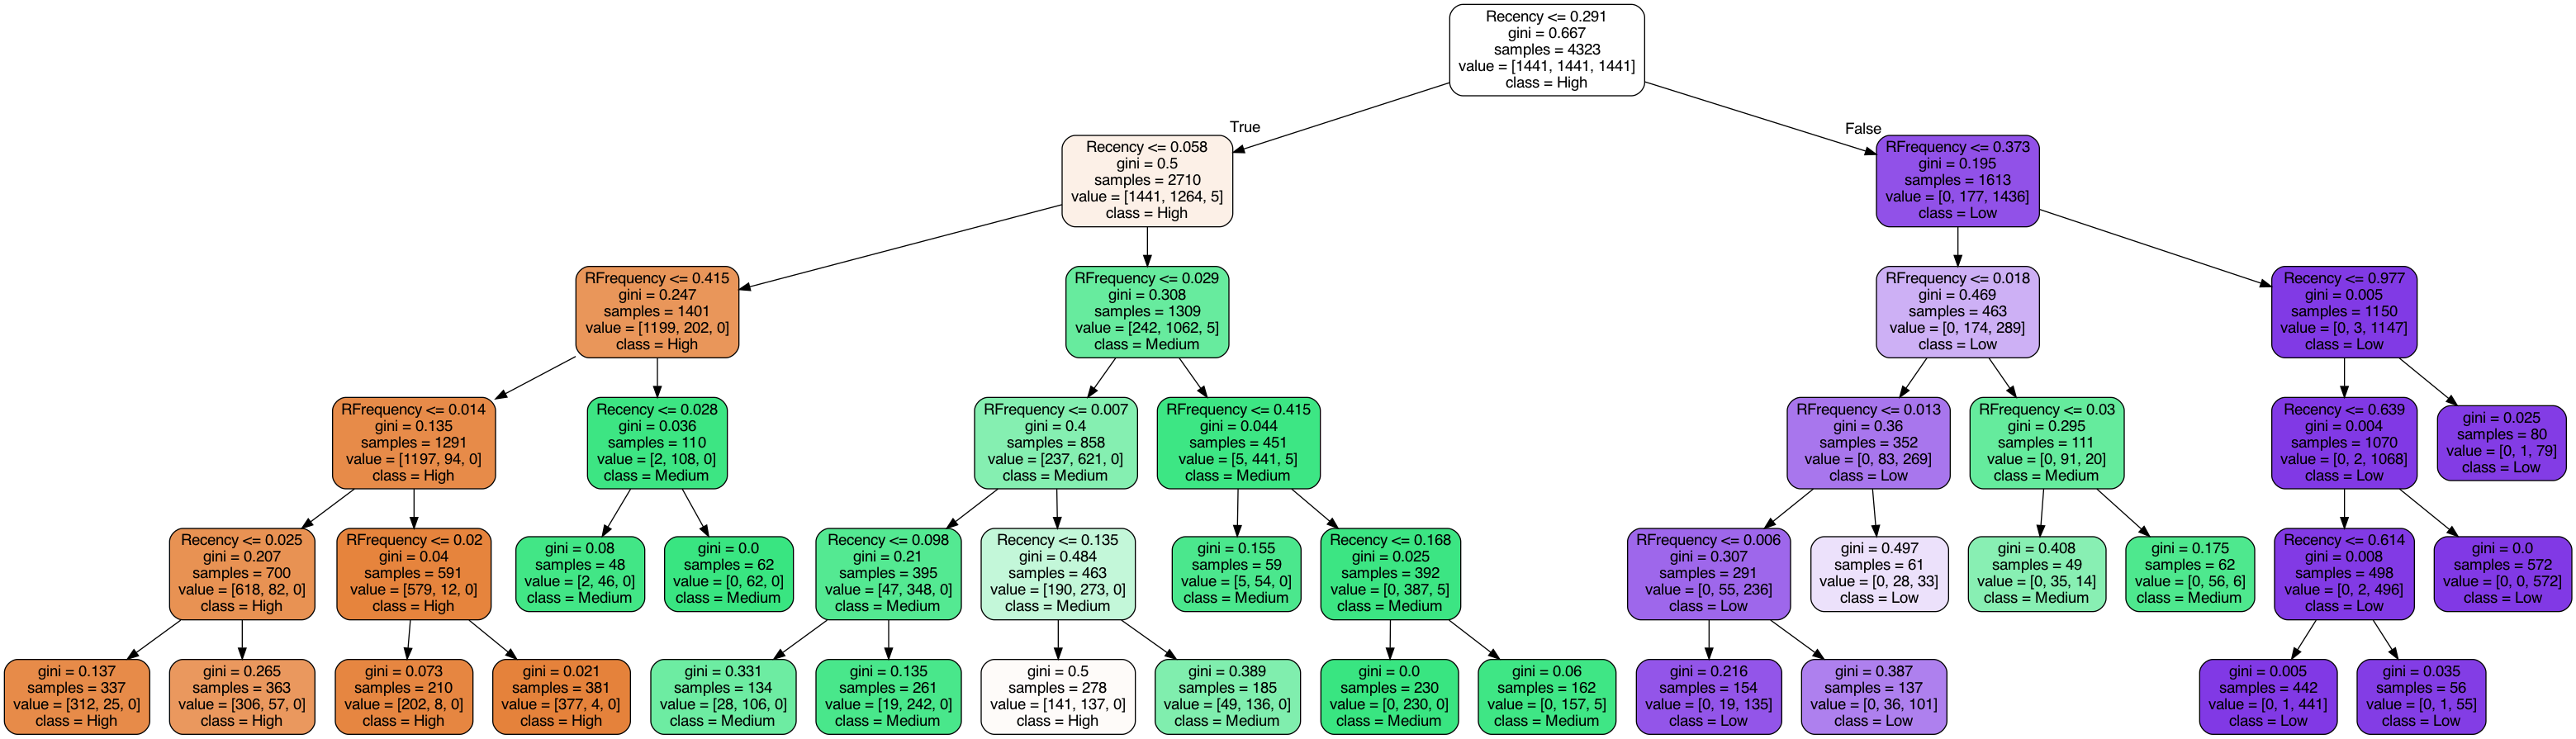

In [21]:
# Show decision tree

dot_data = tree.export_graphviz(dec_t, out_file=None,
                                feature_names=['Recency', 'RFrequency'],
                                class_names=['High', 'Medium', 'Low'],
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [22]:
def predict(model, train_set, test_set):
    train_pred = model.predict(train_set)
    test_pred = model.predict(test_set)
    return train_pred, test_pred

In [23]:
train_pred_dt, test_pred_dt = predict(dec_t, train_set, test_set)

### Evaluation of the decision tree: compute accuracy, precision, recall, confusion matrix

In [24]:
def print_scores(train_label, train_pred, test_label, test_pred, target_names_):
    print('Accuracy train set:', metrics.accuracy_score(train_label, train_pred))
    print('Accuracy test set: ', metrics.accuracy_score(test_label, test_pred))
    print()
    print('F1 score train set:', metrics.f1_score(train_label, train_pred, average='weighted'))
    print('F1 score test set: ', metrics.f1_score(test_label, test_pred, average='weighted'))
    print('Train:')
    print(classification_report(train_label, train_pred, target_names=target_names_))
    print('-' * 53)
    print('Test:')
    print(classification_report(test_label, test_pred, target_names=target_names_))

In [25]:
print_scores(train_label, train_pred_dt, test_label, test_pred_dt, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8970622253065001
Accuracy test set:  0.8921251348435815

F1 score train set: 0.8953589019936822
F1 score test set:  0.8898832190539899
Train:
              precision    recall  f1-score   support

        High       0.85      0.93      0.89      1441
      Medium       0.90      0.78      0.83      1441
         Low       0.94      0.98      0.96      1441

    accuracy                           0.90      4323
   macro avg       0.90      0.90      0.90      4323
weighted avg       0.90      0.90      0.90      4323

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.84      0.92      0.88       618
      Medium       0.90      0.76      0.82       618
         Low       0.94      0.99      0.96       618

    accuracy                           0.89      1854
   macro avg       0.89      0.89      0.89      1854
weighted avg       0.89      0.89      0.89      1854



In [26]:
# compute confusion matrix

print('Train:')
print(confusion_matrix(train_label, train_pred_dt))
print('-' * 18)
print('Test:')
print(confusion_matrix(test_label, test_pred_dt))

Train:
[[1338  103    0]
 [ 231 1124   86]
 [   0   25 1416]]
------------------
Test:
[[571  47   0]
 [108 470  40]
 [  0   5 613]]


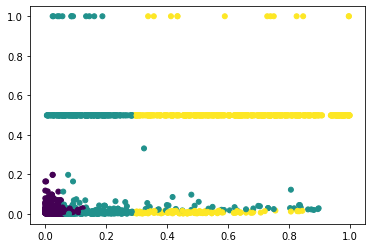

In [27]:
# x: Recency
# y: Frequency
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_pred_dt, s=25)

## SVM

In [28]:
# Binarize the output
test_label_binarized = label_binarize(test_label, classes=[0, 1, 2])
train_label_binarized = label_binarize(train_label, classes=[0, 1, 2])

svm = SVC(kernel='rbf', C=0.75, gamma='scale').fit(train_set, train_label)
svm_binarize = OneVsRestClassifier(svm).fit(train_set, train_label_binarized)

In [29]:
# Predictions

train_pred_svm_binarized, test_pred_svm_binarized = predict(svm_binarize, train_set, test_set)
train_pred_svm, test_pred_svm = predict(svm, train_set, test_set)

In [30]:
# Compute the performance of the model

print_scores(train_label, train_pred_svm, test_label, test_pred_svm, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8628267406893361
Accuracy test set:  0.8646170442286947

F1 score train set: 0.8599768985618651
F1 score test set:  0.8619948865166127
Train:
              precision    recall  f1-score   support

        High       0.82      0.91      0.86      1441
      Medium       0.85      0.71      0.78      1441
         Low       0.92      0.96      0.94      1441

    accuracy                           0.86      4323
   macro avg       0.86      0.86      0.86      4323
weighted avg       0.86      0.86      0.86      4323

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.82      0.90      0.86       618
      Medium       0.85      0.72      0.78       618
         Low       0.92      0.97      0.94       618

    accuracy                           0.86      1854
   macro avg       0.86      0.86      0.86      1854
weighted avg       0.86      0.86      0.86      1854



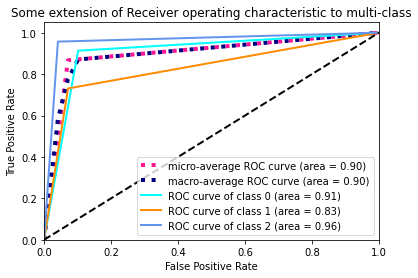

In [31]:
n_classes = 3
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(train_label_binarized[:, i], train_pred_svm_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(train_label_binarized.ravel(), train_pred_svm_binarized.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

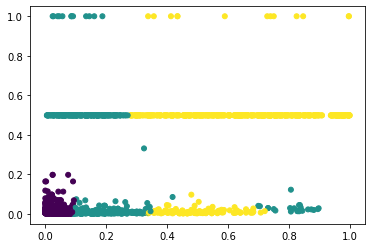

In [32]:
# x: Frequency
# y: Max items
plt.scatter(test_set[:, 0], test_set[:, 1], c= test_pred_svm, s=25)

## KNN

In [33]:
knn = KNeighborsClassifier(n_neighbors=8, metric='minkowski').fit(train_set, train_label)

In [34]:
train_pred_knn, test_pred_knn = predict(knn, train_set, test_set)

In [35]:
print_scores(train_label, train_pred_knn, test_label, test_pred_knn, ['High', 'Medium', 'Low'])

Accuracy train set: 0.9127920425630349
Accuracy test set:  0.8872707659115426

F1 score train set: 0.9119440785765051
F1 score test set:  0.8859011422745146
Train:
              precision    recall  f1-score   support

        High       0.88      0.94      0.91      1441
      Medium       0.90      0.83      0.86      1441
         Low       0.95      0.97      0.96      1441

    accuracy                           0.91      4323
   macro avg       0.91      0.91      0.91      4323
weighted avg       0.91      0.91      0.91      4323

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.85      0.91      0.88       618
      Medium       0.87      0.78      0.82       618
         Low       0.94      0.97      0.95       618

    accuracy                           0.89      1854
   macro avg       0.89      0.89      0.89      1854
weighted avg       0.89      0.89      0.89      1854



## Classification with Random Forest

In [36]:
# To find the best set of parameter setting, we can run a grid search.

param_dist = {"max_depth": [2, 3, 5, 6, 7, 10, 12, None],
              "max_features": sp_randint(1,len(train_set[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight": ['balanced', None, {0: 0.25, 1: 0.50, 2:0.25}]}

n_iter_search = 50

clf = RandomForestClassifier(n_estimators=30)

grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score)).fit(train_set, train_label)

In [37]:
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'max_features': 1, 'min_samples_leaf': 27, 'min_samples_split': 50}
Mean and std of this setting  0.8688444658531363 0.007739045800192006


In [38]:
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=2,
                             class_weight= 'balanced',
                             max_depth=2, 
                             min_samples_split=12,
                             min_samples_leaf=41,
                             bootstrap=False).fit(train_set, train_label)

In [39]:
train_pred_rf, test_pred_rf = predict(rf, train_set, test_set)

In [40]:
print_scores(train_label, train_pred_rf, test_label, test_pred_rf, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8551931529030765
Accuracy test set:  0.8532901833872708

F1 score train set: 0.8521805509347585
F1 score test set:  0.8503195064388114
Train:
              precision    recall  f1-score   support

        High       0.86      0.83      0.84      1441
      Medium       0.81      0.74      0.77      1441
         Low       0.89      1.00      0.94      1441

    accuracy                           0.86      4323
   macro avg       0.85      0.86      0.85      4323
weighted avg       0.85      0.86      0.85      4323

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.86      0.82      0.84       618
      Medium       0.80      0.74      0.77       618
         Low       0.89      1.00      0.94       618

    accuracy                           0.85      1854
   macro avg       0.85      0.85      0.85      1854
weighted avg       0.85      0.85      0.85      1854



## Neural networks

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.python.keras.utils.np_utils import to_categorical

model = Sequential()
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
train_label_nn = to_categorical(train_label, 3)
test_label_nn = to_categorical(test_label, 3)

In [43]:
history = model.fit(train_set, train_label_nn,
                    epochs=200,
                    batch_size=256,
                    validation_split=0.3)

Epoch 1/200
12/12 [==============================] - 0s 19ms/step - loss: 1.0544 - accuracy: 0.3470 - val_loss: 1.0410 - val_accuracy: 0.3624
Epoch 2/200
12/12 [==============================] - 0s 4ms/step - loss: 1.0386 - accuracy: 0.3906 - val_loss: 1.0232 - val_accuracy: 0.4695
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0177 - accuracy: 0.4501 - val_loss: 1.0051 - val_accuracy: 0.5243
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 1.0004 - accuracy: 0.4779 - val_loss: 0.9845 - val_accuracy: 0.5536
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9809 - accuracy: 0.4974 - val_loss: 0.9608 - val_accuracy: 0.5721
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9552 - accuracy: 0.5281 - val_loss: 0.9347 - val_accuracy: 0.5968
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 0.9367 - accuracy: 0.5337 - val_loss: 0.9072 - val_accuracy: 0.6014
Epoch 8/200


Epoch 59/200
12/12 [==============================] - 0s 5ms/step - loss: 0.4167 - accuracy: 0.8275 - val_loss: 0.3380 - val_accuracy: 0.8574
Epoch 60/200
12/12 [==============================] - 0s 4ms/step - loss: 0.4095 - accuracy: 0.8268 - val_loss: 0.3380 - val_accuracy: 0.8558
Epoch 61/200
12/12 [==============================] - 0s 4ms/step - loss: 0.4057 - accuracy: 0.8252 - val_loss: 0.3368 - val_accuracy: 0.8551
Epoch 62/200
12/12 [==============================] - 0s 4ms/step - loss: 0.4081 - accuracy: 0.8255 - val_loss: 0.3358 - val_accuracy: 0.8543
Epoch 63/200
12/12 [==============================] - 0s 4ms/step - loss: 0.4104 - accuracy: 0.8255 - val_loss: 0.3352 - val_accuracy: 0.8558
Epoch 64/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3995 - accuracy: 0.8407 - val_loss: 0.3348 - val_accuracy: 0.8535
Epoch 65/200
12/12 [==============================] - 0s 4ms/step - loss: 0.4005 - accuracy: 0.8348 - val_loss: 0.3341 - val_accuracy: 0.8535
Epoch 

12/12 [==============================] - 0s 5ms/step - loss: 0.3606 - accuracy: 0.8437 - val_loss: 0.3158 - val_accuracy: 0.8558
Epoch 117/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3715 - accuracy: 0.8440 - val_loss: 0.3155 - val_accuracy: 0.8574
Epoch 118/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3773 - accuracy: 0.8493 - val_loss: 0.3154 - val_accuracy: 0.8574
Epoch 119/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3822 - accuracy: 0.8414 - val_loss: 0.3159 - val_accuracy: 0.8574
Epoch 120/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3746 - accuracy: 0.8397 - val_loss: 0.3154 - val_accuracy: 0.8612
Epoch 121/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3769 - accuracy: 0.8404 - val_loss: 0.3161 - val_accuracy: 0.8612
Epoch 122/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3813 - accuracy: 0.8338 - val_loss: 0.3157 - val_accuracy: 0.8566
Epoch 123/200

12/12 [==============================] - 0s 4ms/step - loss: 0.3593 - accuracy: 0.8559 - val_loss: 0.3060 - val_accuracy: 0.8604
Epoch 174/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3629 - accuracy: 0.8447 - val_loss: 0.3056 - val_accuracy: 0.8566
Epoch 175/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3666 - accuracy: 0.8440 - val_loss: 0.3067 - val_accuracy: 0.8604
Epoch 176/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3623 - accuracy: 0.8447 - val_loss: 0.3065 - val_accuracy: 0.8589
Epoch 177/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3601 - accuracy: 0.8473 - val_loss: 0.3068 - val_accuracy: 0.8597
Epoch 178/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3688 - accuracy: 0.8463 - val_loss: 0.3061 - val_accuracy: 0.8574
Epoch 179/200
12/12 [==============================] - 0s 4ms/step - loss: 0.3480 - accuracy: 0.8490 - val_loss: 0.3062 - val_accuracy: 0.8612
Epoch 180/200

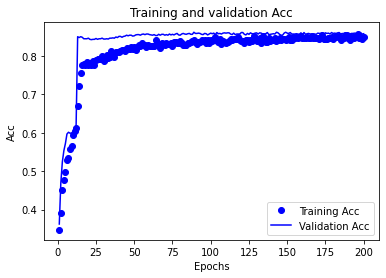

In [44]:
lw = 2
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [45]:
train_pred_nn = np.argmax(model.predict(train_set), axis=-1)
test_pred_nn = np.argmax(model.predict(test_set), axis=-1)

In [46]:
print_scores(train_label, train_pred_nn, test_label, test_pred_nn, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8600508905852418
Accuracy test set:  0.8554476806903991

F1 score train set: 0.8558622484234268
F1 score test set:  0.851344887799024
Train:
              precision    recall  f1-score   support

        High       0.83      0.90      0.86      1441
      Medium       0.86      0.70      0.77      1441
         Low       0.89      0.98      0.94      1441

    accuracy                           0.86      4323
   macro avg       0.86      0.86      0.86      4323
weighted avg       0.86      0.86      0.86      4323

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.83      0.88      0.85       618
      Medium       0.84      0.70      0.76       618
         Low       0.89      0.99      0.94       618

    accuracy                           0.86      1854
   macro avg       0.85      0.86      0.85      1854
weighted avg       0.85      0.86      0.85      1854



## Classification with Naive Bayes

In [47]:
gnb = GaussianNB().fit(train_set, train_label)

train_pred_gnb, test_pred_gnb = predict(gnb, train_set, test_set)

In [48]:
print_scores(train_label, train_pred_gnb, test_label, test_pred_gnb, ['High', 'Medium', 'Low'])

Accuracy train set: 0.799676150821189
Accuracy test set:  0.8069039913700108

F1 score train set: 0.7952111827414163
F1 score test set:  0.8020885400534967
Train:
              precision    recall  f1-score   support

        High       0.74      0.95      0.83      1441
      Medium       0.75      0.60      0.67      1441
         Low       0.93      0.85      0.89      1441

    accuracy                           0.80      4323
   macro avg       0.81      0.80      0.80      4323
weighted avg       0.81      0.80      0.80      4323

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.74      0.94      0.83       618
      Medium       0.77      0.60      0.68       618
         Low       0.93      0.88      0.90       618

    accuracy                           0.81      1854
   macro avg       0.81      0.81      0.80      1854
weighted avg       0.81      0.81      0.80      1854



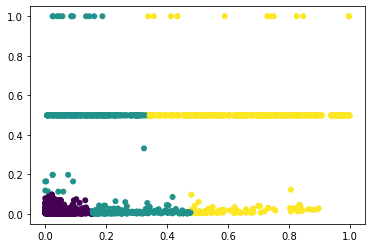

In [49]:
# x: Recency
# y: Frequency
plt.scatter(test_set[:, 0], test_set[:, 1], c= test_pred_gnb, s=25)